.. _props_workflow:

# Properties Workflow

The :py:class:`~.aiida_crystal17.workflows.crystal_props.base.CryPropertiesWorkChain` can be used to compute multiple properties,
using an existing ``fort.9`` file or by running an initial SCF :py:class:`~aiida_crystal17.calculations.cry_main.CryMainCalculation`.

In [1]:
!verdi plugin list aiida.workflows crystal17.properties

Inputs
   check_remote:  optional  Bool                                    If a RemoteData wf_folder is input, check it contains the wavefunction file ...
  clean_workdir:  optional  Bool                                    If `True`, work directories of all called calculation will be cleaned at th ...
           doss:  optional                                          
           ech3:  optional                                          
       metadata:  optional                                          
            scf:  optional                                          
       test_run:  optional  Bool                                    break off the workchain before submitting a calculation
      wf_folder:  optional  FolderData, RemoteData, SinglefileData  the folder containing the wavefunction fort.9 file
Outputs
           doss:  optional                                          
           ech3:  optional                                          
Exit codes
              1:  The

In [8]:
from aiida import engine, load_profile, orm, plugins
from aiida.tools.visualization import Graph
from aiida_crystal17.common import recursive_round
from aiida_crystal17.data.basis_set import BasisSetData
from aiida_crystal17.data.input_params import CryInputParamsData
from aiida_crystal17.tests.utils import (
    get_or_create_local_computer, get_or_create_code,
    get_default_metadata)
from aiida_crystal17.tests import (
    get_test_structure_and_symm, resource_context)
profile = load_profile()
profile.name

'test_crystal17'

In [9]:
wc_builder = plugins.WorkflowFactory('crystal17.properties').get_builder()
computer = get_or_create_local_computer('work_directory', 'localhost')

wc_builder.scf.code = get_or_create_code('crystal17.main', 
                                         computer, 'mock_crystal17')
structure, symmetry = get_test_structure_and_symm('MgO')
wc_builder.scf.structure = structure
wc_builder.scf.symmetry = symmetry
wc_builder.scf.parameters = CryInputParamsData(data={
                'title': 'MgO Bulk',
                'scf': {
                    'k_points': [8, 8],
                    'post_scf': ['PPAN']
                },
            })
with resource_context('basis_sets', 'sto3g') as path:
    BasisSetData.upload_basisset_family(
       path, "sto3g", "group of sto3g basis sets",
       extension=".basis", stop_if_existing=False)
wc_builder.scf.basissets = BasisSetData.get_basissets_from_structure(
    structure, "sto3g")
wc_builder.scf.metadata = get_default_metadata()

wc_builder.doss.code = get_or_create_code('crystal17.doss', 
                                          computer, 'mock_properties17')
wc_builder.doss.parameters = orm.Dict(dict={
                'k_points': [18, 36],
                'npoints': 100,
                'band_minimum': -10,
                'band_maximum': 10,
                'band_units': 'eV'
            })
wc_builder.doss.metadata = get_default_metadata()

wc_builder.ech3.code = get_or_create_code('crystal17.ech3', 
                                          computer, 'mock_properties17')
wc_builder.ech3.parameters = orm.Dict(dict={
                'npoints': 20
            })
wc_builder.ech3.metadata = get_default_metadata()

wc_builder.clean_workdir = True

In [10]:
outputs, wc_node = engine.run_get_node(wc_builder)

In [15]:
!verdi process report {wc_node.pk}

2019-09-24 17:02:37 [61 | REPORT]: [997|CryPropertiesWorkChain|check_wf_folder]: No 'wf_folder' supplied, running SCF Calculation...
2019-09-24 17:02:38 [62 | REPORT]: [997|CryPropertiesWorkChain|submit_scf_calculation]: launched SCF calculation: uuid: 80c1d604-504c-46e3-abe3-3cba696dd09d (pk: 998) (aiida.calculations:crystal17.main)
2019-09-24 17:02:52 [63 | REPORT]: [997|CryPropertiesWorkChain|check_scf_calculation]: uuid: 80c1d604-504c-46e3-abe3-3cba696dd09d (pk: 998) (aiida.calculations:crystal17.main) finished successfully
2019-09-24 17:02:52 [64 | REPORT]: [997|CryPropertiesWorkChain|submit_prop_calculations]: launched doss calculation uuid: fc38e33a-2786-4e2d-b154-ec03df427b1e (pk: 1002) (aiida.calculations:crystal17.doss)
2019-09-24 17:02:52 [65 | REPORT]: [997|CryPropertiesWorkChain|submit_prop_calculations]: launched ech3 calculation uuid: a7ec5251-c94d-47e2-9f79-7491c7d239ec (pk: 1003) (aiida.calculations:crystal17.ech3)
2019-09-24 17:03:03 [66 | REPORT]: [997|CryPropertiesW

In [14]:
!verdi process show {wc_node.pk}

Property       Value
-------------  ------------------------------------
type           WorkChainNode
pk             997
uuid           00f27214-1aad-405e-bc73-0151bab4f873
label
description
ctime          2019-09-24 17:02:37.060297+00:00
mtime          2019-09-24 17:03:03.295586+00:00
process state  Finished
exit status    0
computer       [1] localhost

Inputs          PK    Type
--------------  ----  ------------------
doss
    parameters  994   Dict
    code        881   Code
ech3
    parameters  995   Dict
    code        971   Code
scf
    parameters  993   CryInputParamsData
    symmetry    992   SymmetryData
    structure   990   StructureData
    code        445   Code
    basissets
        O       44    BasisSetData
        Mg      704   BasisSetData
clean_workdir   996   Bool

Outputs            PK    Type
-----------------  ----  ------------
doss
    remote_folder  1004  RemoteData
    retrieved      1006  FolderData
    results        1008  Dict
    arrays         1009  A

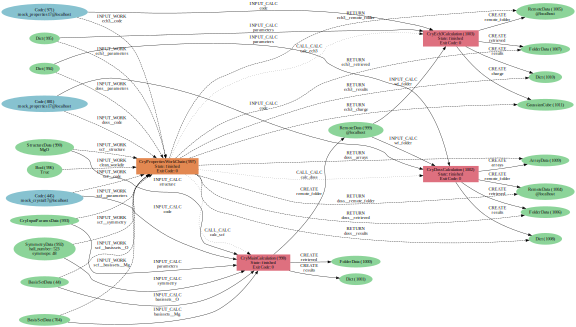

In [37]:
graph = Graph(graph_attr={'size': "8,6!", "rankdir": "LR"})
graph.recurse_ancestors(
    wc_node,
    depth=1,
    include_process_outputs=False, 
    annotate_links="both")
graph.recurse_descendants(
    wc_node,
    depth=None,
    include_process_inputs=True, 
    annotate_links="both")
graph.graphviz